# Pearson Correlation Formula
$$ r = \frac{\sum{(X_i - \overline{X})(Y_i - \overline{Y})}}{\sqrt{\sum{(X_i - \overline{X})^2 \sum{(Y_i - \overline{Y})^2}}}} $$
Where:
- $ X_i $ and $ Y_i $ are individual data points
- $ \overline{X} $ and $ \overline{Y} $ are the means of $ X $ and $ Y $

## Numpy Method

In [141]:
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn.linear_model import LinearRegression 

returns = np.array([0.32, -0.6, -0.08, 1.05, 1.52, 0.6, 1.51])  # daily return in percent
volatility = np.array([20.1, 20.2, 20.1, 20.1, 20.2, 20.05, 20.5])  # implied vol in percent

correlation = np.corrcoef(returns, volatility)[0, 1]
print(f"Correlation: {correlation:.2f}")

Correlation: 0.45


## Manual

### Stock Data

In [142]:
import yfinance as yfin
ticker = yfin.Ticker("QQQ")
data = ticker.history(start='2020-06-15', end='2025-06-15', interval='1d')

$$ X_{t+1} - X_t = \kappa(\theta - X_t) \Delta t + \epsilon_t $$
$$ X_{t+1} = \alpha + \beta X_t + \epsilon_t$$
Then: 
- $ \kappa = -ln(\beta) / \Delta t $
- $ \theta = \alpha / (1 - \beta) $

┌──────────────────────────────────────────────┐
│  ← QQQ Heston Model Estimated Parameters →  │
├──────────────────────────────────────────────┤
│ Correlation (ρ)            :  -0.28          │
│ Long-term Variance Mean (θ): 0.04904         │
│ Volatility of Volatility (σ): 69.92%         │
│ Speed of Mean Reversion (κ) : 1.9747840      │
└──────────────────────────────────────────────┘


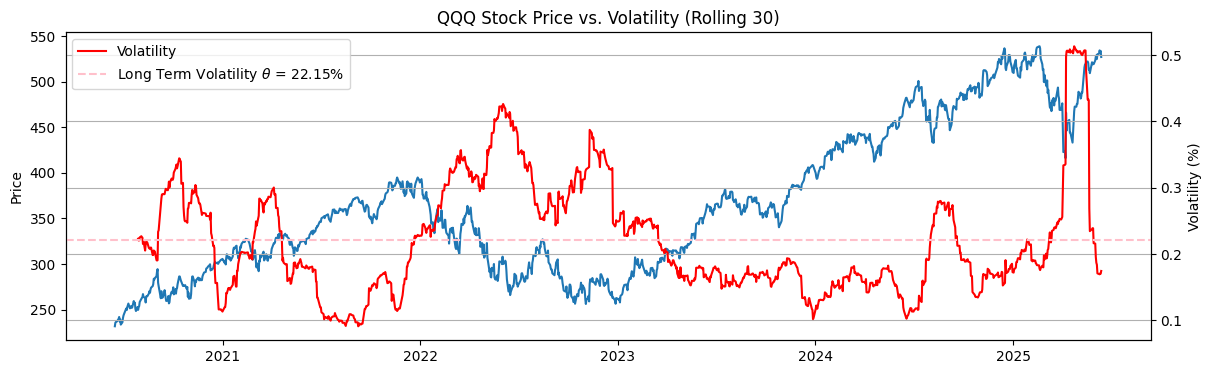

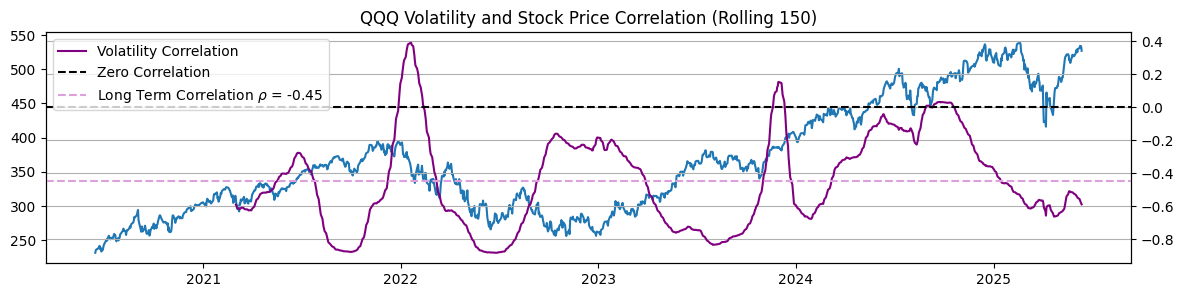

In [143]:
import pandas as pd
vol_start_i = 30
corr_start_i = vol_start_i * 5
data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(vol_start_i).std() * (math.sqrt(252))
data['Correlation'] = data['Close'].rolling(corr_start_i).corr(data['Volatility'])
mean_corr = np.nanmean(data['Correlation'].values)
returns = data['Return'].values[vol_start_i:]
prices = data['Close'].values[vol_start_i:]
vols = data['Volatility'].values[vol_start_i:]
mean_vol = np.nanmean(data['Volatility'].values)
fig, ax1 = plt.subplots(figsize=(14, 4))
plt.title(f"{ticker.ticker} Stock Price vs. Volatility (Rolling {vol_start_i})")
ax1.plot(data['Close'], label='Stock Price')
ax1.set_ylabel("Price")
ax2 = ax1.twinx()
ax2.plot(data['Volatility'], label='Volatility', color='red')
ax2.axhline(mean_vol, color='pink', linestyle='--', label=f'Long Term Volatility $ \\theta $ = {mean_vol*100:.2f}%')
ax2.set_ylabel("Volatility (%)")
plt.grid()
ax2.legend()

fig, ax1 = plt.subplots(figsize=(14, 3))
plt.title(f"{ticker.ticker} Volatility and Stock Price Correlation (Rolling {corr_start_i})")
ax1.plot(data['Close'], label='Stock Price')
ax2 = ax1.twinx()
ax2.plot(data['Correlation'], label='Volatility Correlation', color='purple')
ax2.axhline(0, color='k', linestyle='--', label='Zero Correlation')
ax2.axhline(mean_corr, color='plum', linestyle='--', label=f'Long Term Correlation $ \\rho $ = {mean_corr:.2f}')
plt.grid()
plt.legend()
def get_correlation(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    return numerator / denominator

rho = round(get_correlation(prices, vols),2)
theta = (mean_vol**2) 
log_vols = pd.Series(np.log(vols)).dropna()
sigma = log_vols.diff().std() * np.sqrt(252)

def estimate_kappa(x, dt=1.0):
    x = np.array(x)
    x_t = x[:-1]
    x_t1 = x[1:]

    model = LinearRegression().fit(x_t.reshape(-1, 1), x_t1)

    beta = model.coef_[0]
    alpha = model.intercept_
    kappa = -np.log(beta) / dt
    theta = alpha / (1 - beta)
    return kappa, theta

kappa, new_theta = estimate_kappa(vols) # daily kappa, yearly theta
print("┌──────────────────────────────────────────────┐")
print(f"│  ← {ticker.ticker} Heston Model Estimated Parameters →  │")
print("├──────────────────────────────────────────────┤")
print(f"│ Correlation (ρ)            : {rho:>6.2f}          │")
print(f"│ Long-term Variance Mean (θ): {theta:>6.5f}         │")
print(f"│ Volatility of Volatility (σ): {sigma*100:>3.2f}%         │")
print(f"│ Speed of Mean Reversion (κ) : {kappa*252:>3.7f}      │")
print("└──────────────────────────────────────────────┘")


df = pd.DataFrame({
    "Parameter": ["Correlation (ρ)", "Long-term Variance Mean (θ)"],
    "Value": [rho, f"{theta}%"]
})
